# Monet Style Image Generation With CycleGAN & DCGAN

## CycleGAN Fine Tuning

The work presented in this section relies heavily on the code and workflow of the tutorial notebook for this Kaggle competition found below:

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

The tutorial also makes use of TPUs and TFRecords.

Near the end of this section, optimizing the CycleGAN implementation for improved Memorization-informed Fréchet Inception Distance (MiFID) is discussed.

A lower MiFID is desired. The Kaggle competition provides more details about the evaluation metric:

https://www.kaggle.com/competitions/gan-getting-started/overview/evaluation

### Imports

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from kaggle_datasets import KaggleDatasets
import shutil


2022-12-08 14:30:57.585109: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-08 14:30:57.585278: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    

print(tf.__version__)

Device: grpc://10.0.0.2:8470


2022-12-08 14:31:03.700878: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-08 14:31:03.703560: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-08 14:31:03.703600: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-08 14:31:03.703633: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4e8b10c42cc9): /proc/driver/nvidia/version does not exist
2022-12-08 14:31:03.707298: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


### Loading Data

In [ ]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


2022-12-08 14:31:10.508690: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-08 14:31:10.616750: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [ ]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

The images are 256 X 256 pixels.

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [ ]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

### Exploratory Data Analysis (EDA)

In [ ]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Below are a sample image from the photo data set and the Monet painting data set. Eventually a pair of generators will be able to construct a Monet version of photos and a photo-realistic version of Monet paintings. Only the Monet-style generated images are evaluated though.

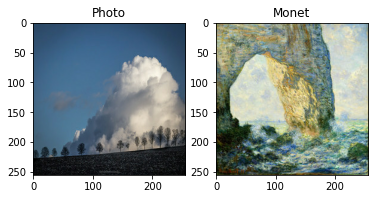

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

CycleGAN is a natural choice for this competition as there are 7000 photos and only 300 Monet images with evaluation to be done on a required set of 7000 - 10000 generated images. Using the photo to Monet part of the cycle, one generator will be able to generate 7000 Monet-style versions of the photos that are passed on for evaluation.  Alternative strategies that use only the Monet images may comparatively struggle with a relative lack of data. We will investigate DCGAN using only the Monet images later on.

### Modeling

In [ ]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Upsampling and downsampling the images are the building blocks of the generator and discriminator in many GANs and in particular with CycleGAN. This allows for appropriate features to be learned and passed through the networks.


In [ ]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)


Fine tuning the CycleGAN by adjusting the upsampling and downsampling layers is very finicky due to dimension matching requirements and memory resource intensiveness which may lead to large tensors causing the kernel to crash.

In [ ]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

The CycleGan class can now be defined using the prior code blocks.

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

Next are the loss functions used for updating weights.

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5


In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

CycleGAN's pair of generators partially learn from the loss after passing an image through both generators and seeing how close to the initial image the recreated output is.

### Fine Tuning

Below are some of the hyperparameters that can be fine-tuned for a better MiFID score. The Adam optimizer has a learning rate and a beta_1 parameter which is tied to the decay of the learning rate. The incremental improvements and adversarial nature of the generator and discriminator in GANs are dependent on stability. Below are the defaults in the original referenced notebook implementation.

In [ ]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

 Adjusting the number of epochs may also be beneficial with 25 used in the default implementation.
 
The above were updated to the following in three separate instances, each leading to an improved performance (as per MiFID using the subsequent Monet generated images) over the prior instance:
 
1) lr = 2e-4, beta_1=0.6, epochs = 10
 
2) lr  = 3e-4, beta_1=0.6, epoches = 20
 
3) lr = 3e-4, beta_1=0.6, epochs = 50

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

Below is the optimal (third) training run.

In [ ]:
# With Beta_2 = 0.6 in adam optimizers and alpha increase to 3e-4
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=50 # Increased from default 25
)

Epoch 1/50
300/300 [==============================] - 131s 127ms/step - monet_gen_loss: 4.7902 - photo_gen_loss: 4.9802 - monet_disc_loss: 0.6751 - photo_disc_loss: 0.6404
Epoch 2/50
  1/300 [..............................] - ETA: 54s - monet_gen_loss: 2.9888 - photo_gen_loss: 2.6610 - monet_disc_loss: 0.5924 - photo_disc_loss: 0.6268

2022-12-09 03:02:21.168982: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 13241, Output num: 2
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670554941.165510825","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 13241, Output num: 2","grpc_status":3}


300/300 [==============================] - 38s 126ms/step - monet_gen_loss: 3.5658 - photo_gen_loss: 3.6542 - monet_disc_loss: 0.6594 - photo_disc_loss: 0.6486
Epoch 3/50
300/300 [==============================] - 38s 126ms/step - monet_gen_loss: 3.3472 - photo_gen_loss: 3.4001 - monet_disc_loss: 0.6529 - photo_disc_loss: 0.6551
Epoch 4/50
300/300 [==============================] - 38s 127ms/step - monet_gen_loss: 3.1531 - photo_gen_loss: 3.2001 - monet_disc_loss: 0.6376 - photo_disc_loss: 0.6368
Epoch 5/50
300/300 [==============================] - 38s 127ms/step - monet_gen_loss: 3.0832 - photo_gen_loss: 3.1138 - monet_disc_loss: 0.6254 - photo_disc_loss: 0.6329
Epoch 6/50
300/300 [==============================] - 38s 127ms/step - monet_gen_loss: 3.0530 - photo_gen_loss: 3.0714 - monet_disc_loss: 0.6165 - photo_disc_loss: 0.6275
Epoch 7/50
300/300 [==============================] - 38s 126ms/step - monet_gen_loss: 2.9991 - photo_gen_loss: 3.0244 - monet_disc_loss: 0.6223 - photo_dis

Note the Monet generator loss on its cannot suggest whether the MiFID will be low as it is trained from scratch with a pair discriminator which is not universal in nature.

Some generated images from the optimal training run are shown below.

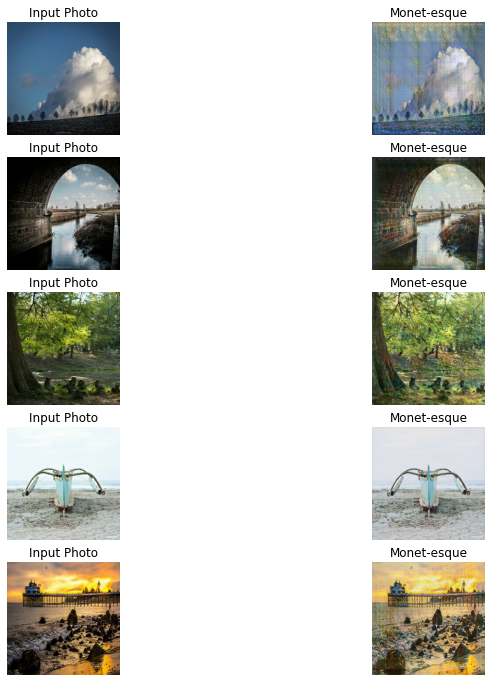

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

The below code generates the full 7000+ images requried for evaluation.

In [ ]:
import PIL
! mkdir ../images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

2022-12-08 10:53:32.170436: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 4659167, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670496812.170259262","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 4659167, Output num: 0","grpc_status":3}


In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

## DCGAN

The DCGAN implementation heavily follows the code and workflow found here: https://keras.io/examples/generative/dcgan_overriding_train_step/

Some adjustments were required however. In the implementation above, images are downsampled and 64X64 pixel images are generated instead of 256X256 in the Kaggle competition. Thus tweaks to the upsampling and downsampling layers are required in the discriminator and generator.

Often the discriminator (as can sometimes be the case) dominated the generator which was eventually mitigated by reducing the beta_1 parameter from the default 0.9 and running the training for many more epochs.

### Exploratory Data Analysis (EDA)

Here only the 300 Monet images are used to train a single generator and discrimator. Below are 20 of the Monet images. Images instead of TFRecords are now used (also GPUs were used instead of TPUs). A batch size of 16 is required to avoid crashing the Kaggle kernel due to memory requirements.

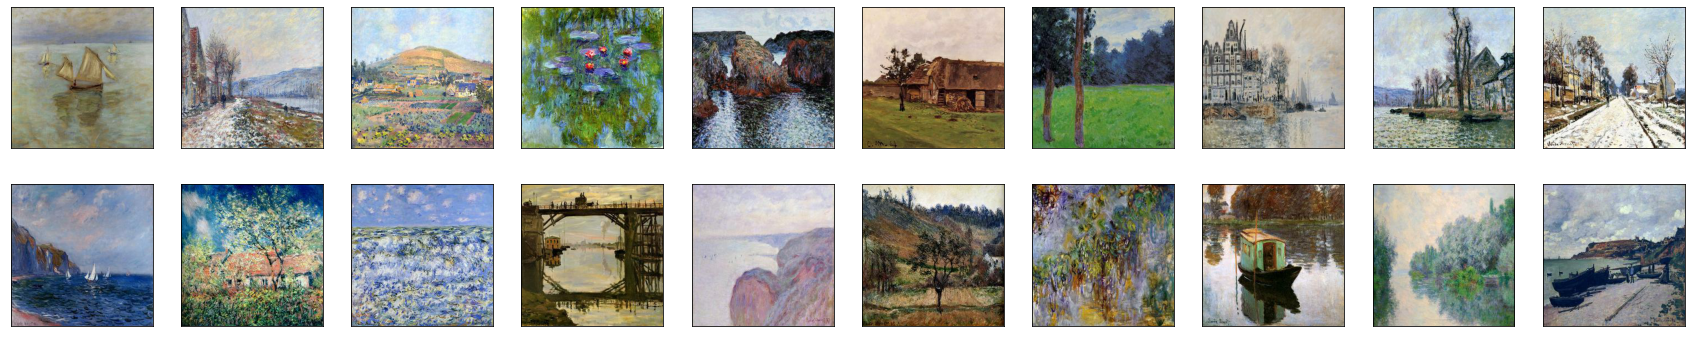

In [ ]:
import os
from PIL import Image
fig = plt.figure(figsize=(30, 6))
train_imgs = os.listdir("/kaggle/input/gan-getting-started/monet_jpg")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("/kaggle/input/gan-getting-started/monet_jpg/" + img)
    plt.imshow(im)

In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/gan-getting-started/monet_jpg", label_mode=None, image_size=(256, 256), batch_size=16
)
dataset = dataset.map(lambda x: x / 255.0)

Found 300 files belonging to 1 classes.


### Modeling

Note again the discriminator and generator have been amended from 64X64 input / output to 256X256.

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)          

In [ ]:
latent_dim = 64 # Redcued from 128 in original implementation for memory constraints.

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=4, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=4, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              532480    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 256)     524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128, 128, 256)     0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 256, 256, 512)     20

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

Four DCGANs were constructed with each improving on the prior instance (again as per MiFID using the subsequent Monet generated images):

1) lr = 1e-4, beta_1=0.9, epochs = 100

2) lr = 1e-4, beta_1=0.9, epoches = 300

3) lr= 1e-4, beta_1=0.6, epochs = 150

4) lr= 1e-4, beta_1=0.6, epochs = 250

Below is the optimal (fourth) training run.

In [ ]:
epochs = 250 

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.6),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.6),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs
)

Epoch 1/250


2022-12-09 04:38:47.120686: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


19/19 [==============================] - 34s 1s/step - d_loss: 0.5564 - g_loss: 1.0227
Epoch 2/250
19/19 [==============================] - 19s 1s/step - d_loss: 0.4743 - g_loss: 1.4131
Epoch 3/250
19/19 [==============================] - 19s 1s/step - d_loss: 0.4749 - g_loss: 1.2315
Epoch 4/250
19/19 [==============================] - 19s 1s/step - d_loss: 0.6809 - g_loss: 0.6870
Epoch 5/250
19/19 [==============================] - 19s 1s/step - d_loss: 0.5354 - g_loss: 1.1465
Epoch 6/250
19/19 [==============================] - 19s 1s/step - d_loss: 0.5628 - g_loss: 1.0852
Epoch 7/250
19/19 [==============================] - 19s 1s/step - d_loss: 0.5905 - g_loss: 1.1945
Epoch 8/250
19/19 [==============================] - 19s 1s/step - d_loss: 0.4487 - g_loss: 1.4747
Epoch 9/250
19/19 [==============================] - 19s 1s/step - d_loss: 0.5080 - g_loss: 1.2101
Epoch 10/250
19/19 [==============================] - 19s 1s/step - d_loss: 0.3300 - g_loss: 1.6648
Epoch 11/250
19/19 [=

Here are some sample images which have a Monet aesthetic but are still quite abstract in nature (though this fourth DCGAN definitely produced the best images from a visual perspective). Perhaps even more epochs are required.

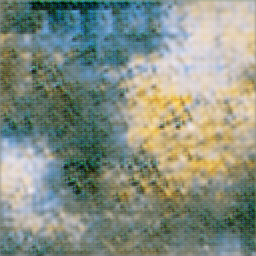

In [ ]:
noise = tf.random.normal([5, 64])
generated_images = generator(noise)
generated_images *= 255.0
generated_images.numpy()
img = keras.preprocessing.image.array_to_img(generated_images[0])
img


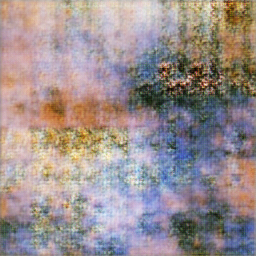

In [ ]:
img = keras.preprocessing.image.array_to_img(generated_images[1])
img


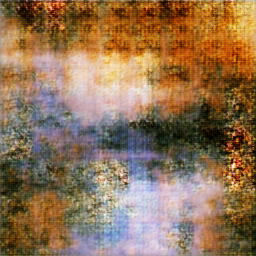

In [ ]:
img = keras.preprocessing.image.array_to_img(generated_images[2])
img


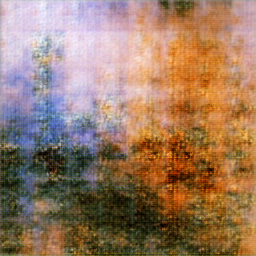

In [ ]:
img = keras.preprocessing.image.array_to_img(generated_images[3])
img


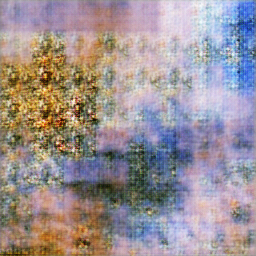

In [ ]:
img = keras.preprocessing.image.array_to_img(generated_images[4])
img


The slightly different below code generates the full 7000+ images requried for evaluation.

In [ ]:
import PIL
! mkdir ../images

for i in range(7005):
    noise = tf.random.normal([1, 64])
    generated_images = generator(noise)
    generated_images *= 255.0
    generated_images.numpy()
    img = keras.preprocessing.image.array_to_img(generated_images[0])
    img.save("../images/" + str(i) + ".jpg")

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

## Results Summary

For CycleGAN the model parameters and MiFID are as follows:

|Learning Rate|Beta_1|Epochs| MiFID|
|:----|:----|:----|:--------:|
|2e-4|0.6|10|71.08385|
|3e-4|0.6|20|65.05598|
|3e-4|0.6|50|55.20923|

The third model has the lowest MiFID and thus performed best. 


DCGAN was not able to peform as well as CycleGAN as can be seen from the generated images even in the last model. For DCGAN the model parameters and MiFID are as follows:


|Learning Rate|Beta_1|Epochs| MiFID|
|:----|:----|:----|:--------:|
|1e-4|0.9|100|306.80494|
|1e-4|0.9|300|267.63991|
|1e-4|0.6|150|161.40772|
|1e-4|0.6|250|132.61797|

The fourth model performed best.


Clearly CycleGAN outperformed DCGAN with a more sophisticated implementation and relying on a large photo data set to generate the Monet images. Image augmentation by zoom, rotation and translation may benefit DCGAN as only 300 Monet images were in the data set for training. CycleGAN could potentially improve even further with additional tweaking and running the training for more epochs.

## References

[1] https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

[2] https://keras.io/examples/generative/dcgan_overriding_train_step/